In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

In [2]:
df_sp = pd.read_csv('../data/interim/1_0_data_sp.csv')
df_sem = pd.read_csv('../data/interim/1_1_data_sem.csv')

In [3]:
len(df_sp.id.unique())

28

In [4]:
df_sp.head(1)

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age
0,172843326579763,1016.090081,401.723052,1021.80528,395.415,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0


## Data Preprocessing

### Drop Null Value

In [5]:
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33558 entries, 0 to 33557
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       33558 non-null  int64  
 1   MovingTarget_X  33558 non-null  float64
 2   MovingTarget_Y  33558 non-null  float64
 3   EyeTracker_X    33558 non-null  float64
 4   EyeTracker_Y    33558 non-null  float64
 5   name            33558 non-null  object 
 6   date            33558 non-null  object 
 7   category        33558 non-null  object 
 8   id              33558 non-null  object 
 9   row_id          32357 non-null  float64
 10  HR_before       32357 non-null  float64
 11  HR_after        31156 non-null  float64
 12  age             31156 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 3.3+ MB


In [6]:
len(df_sp.row_id.unique())

28

In [7]:
# df_sp = df_sp.drop(['perc_O2'], axis = 1)
# df_sem = df_sem.drop(['perc_O2'], axis = 1)

In [8]:
df_sp = df_sp.dropna()

df_sem = df_sem.dropna()

In [9]:
len(df_sp.row_id.unique())

26

# Feature Engineering

## Smooth Pursuit

In [10]:
df_sp.head()

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age
0,172843326579763,1016.090081,401.723052,1021.805280,395.415000,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0
1,172843326671260,1019.829718,439.893571,1024.466342,406.894995,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0
2,172843326675478,1019.882231,441.594809,1025.091014,410.885316,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0
3,172843326679578,1019.924879,443.286799,1025.208144,412.747227,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0
4,172843326683727,1019.957807,444.968713,1025.414424,414.661788,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0


Counting Distance

In [11]:
# Counting Distance
df_sp['sp_distance'] = (df_sp['MovingTarget_X'] - df_sp['EyeTracker_X'])**2 + (df_sp['MovingTarget_Y'] - df_sp['EyeTracker_Y'])**2

df_sp['sp_distance'] = np.sqrt(df_sp['sp_distance'])

df_sp.head()

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age,sp_distance
0,172843326579763,1016.090081,401.723052,1021.805280,395.415000,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,8.512051
1,172843326671260,1019.829718,439.893571,1024.466342,406.894995,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,33.322729
2,172843326675478,1019.882231,441.594809,1025.091014,410.885316,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,31.148104
3,172843326679578,1019.924879,443.286799,1025.208144,412.747227,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.993199
4,172843326683727,1019.957807,444.968713,1025.414424,414.661788,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.794226


Counting angle

In [12]:
screen_width = 1920
screen_height = 1080

screen_center = [screen_width//2, screen_height//2] 

df_sp_angle = df_sp.copy()

df_sp_angle['vector_e_x'] = df_sp_angle['EyeTracker_X'] - screen_center[0]
df_sp_angle['vector_e_y'] = df_sp_angle['EyeTracker_Y'] - screen_center[1]

df_sp_angle['vector_g_x'] = df_sp_angle['MovingTarget_X'] - screen_center[0]
df_sp_angle['vector_g_y'] = df_sp_angle['MovingTarget_Y'] - screen_center[1]

# df_sp['vector_e'] = [df_sp['vector_e_x'], df_sp['vector_e_y']]
# df_sp['vector_g'] = [df_sp['vector_g_x'], df_sp['vector_g_y']]

df_sp_angle['vector_e_length'] = df_sp_angle['vector_e_x']**2 + df_sp_angle['vector_e_y']**2
df_sp_angle['vector_e_length'] = np.sqrt(df_sp_angle['vector_e_length'])

df_sp_angle['vector_g_length'] = df_sp_angle['vector_g_x']**2 + df_sp_angle['vector_g_y']**2
df_sp_angle['vector_g_length'] = np.sqrt(df_sp_angle['vector_g_length'])

df_sp_angle['vector_e_dot_g'] = df_sp_angle['vector_e_x'] * df_sp_angle['vector_g_x'] + df_sp_angle['vector_e_y'] * df_sp_angle['vector_g_y']

df_sp_angle['sp_angle'] = np.arccos(df_sp_angle['vector_e_dot_g'] / (df_sp_angle['vector_e_length'] * df_sp_angle['vector_g_length']))

In [13]:
df_sp['sp_angle'] = df_sp_angle['sp_angle']
df_sp.head()

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age,sp_distance,sp_angle
0,172843326579763,1016.090081,401.723052,1021.805280,395.415000,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,8.512051,0.018603
1,172843326671260,1019.829718,439.893571,1024.466342,406.894995,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,33.322729,0.087667
2,172843326675478,1019.882231,441.594809,1025.091014,410.885316,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,31.148104,0.079717
3,172843326679578,1019.924879,443.286799,1025.208144,412.747227,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.993199,0.081175
4,172843326683727,1019.957807,444.968713,1025.414424,414.661788,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.794226,0.081834


### Aggregation for Smooth Pursuit

In [14]:
df_sp.head()

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age,sp_distance,sp_angle
0,172843326579763,1016.090081,401.723052,1021.805280,395.415000,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,8.512051,0.018603
1,172843326671260,1019.829718,439.893571,1024.466342,406.894995,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,33.322729,0.087667
2,172843326675478,1019.882231,441.594809,1025.091014,410.885316,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,31.148104,0.079717
3,172843326679578,1019.924879,443.286799,1025.208144,412.747227,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.993199,0.081175
4,172843326683727,1019.957807,444.968713,1025.414424,414.661788,ar,2024-10-09,SP,ar-2024-10-09_SP_1728433242,1.0,72.0,120.0,21.0,30.794226,0.081834


In [15]:
df_sp_row_id = df_sp[['id','row_id']].drop_duplicates()
df_sp = df_sp[['id', 'HR_before', 'HR_after', 'sp_distance', 'sp_angle']]

# Group by 'category' and apply aggregation functions
df_sp_sum = df_sp.groupby('id').agg({
    'sp_distance': 'sum',    # Sum the values in 'values_1'
    'sp_angle': 'sum'    # Calculate the mean of 'values_2'
})

# Group by 'category' and apply aggregation functions
df_sp_average = df_sp.groupby('id').agg({
    'sp_distance': 'mean',    # Sum the values in 'values_1'
    'sp_angle': 'mean'    # Calculate the mean of 'values_2'
})

# Group by 'category' and apply aggregation functions
df_sp_median = df_sp.groupby('id').agg({
    'sp_distance': 'median',    # Sum the values in 'values_1'
    'sp_angle': 'median'    # Calculate the mean of 'values_2'
})

df_sp = df_sp[['id', 'HR_before', 'HR_after']]
df_sp = df_sp.groupby('id').agg('mean')

df_sp['sp_total_distance'] = df_sp_sum['sp_distance']
df_sp['sp_average_distance'] = df_sp_average['sp_distance']
df_sp['sp_median_distance'] = df_sp_median['sp_distance']

df_sp['sp_total_angle'] = df_sp_sum['sp_angle']
df_sp['sp_average_angle'] = df_sp_average['sp_angle']
df_sp['sp_median_angle'] = df_sp_median['sp_angle']

df_sp = df_sp.reset_index()
df_sp = pd.merge(df_sp, df_sp_row_id, on='id', how='inner')

In [16]:
df_sp.head(15)

,id,HR_before,HR_after,sp_total_distance,sp_average_distance,sp_median_distance,sp_total_angle,sp_average_angle,sp_median_angle,row_id
0,aaliyah-2024-10-21_SP_1729492081,94.0,141.0,79099.036519,69.690781,55.565160,229.927899,0.202580,0.074614,26.0
1,ar-2024-10-09_SP_1728433242,72.0,120.0,40146.187277,33.427300,30.113397,118.172835,0.098395,0.056699,1.0
2,ar-2024-10-10_SP_1728533147,84.0,134.0,32685.571041,27.215296,25.021036,204.802680,0.170527,0.090627,3.0
3,ar-2024-10-12_SP_1728718590,94.0,146.0,44043.556311,36.672403,35.104838,131.801018,0.109743,0.060777,5.0
4,ar-2024-10-13_SP_1728792490,83.0,132.0,28703.569543,23.899725,16.529260,101.726948,0.084702,0.033269,9.0
5,ar-2024-10-14_SP_1728863077,70.0,132.0,28257.159878,23.528027,22.943240,115.369011,0.096061,0.057553,11.0
6,ar-2024-10-15_SP_1728983092,68.0,124.0,29204.750171,24.317028,21.586166,132.737140,0.110522,0.056654,13.0
7,ar-2024-10-22_SP_1729587421,68.0,144.0,34262.910751,28.528652,23.436273,94.747562,0.078891,0.052490,29.0
8,ar-2024-10-29_SP_1730192936,78.0,116.0,34770.409219,28.951215,22.129910,116.760944,0.097220,0.042896,31.0
9,bella-2024-10-18_SP_1729238753,85.0,140.0,54624.286073,45.482336,34.291648,206.149969,0.171649,0.065083,19.0


In [17]:
len(df_sp.row_id.unique())

26

## Saccadic Eye Movement

NOTE: THIS SECTION STILL NEED MORE ATTENTION

In [18]:
df_sem.tail(5)

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age
32093,173019308333226,1020.0,450.0,984.489840,497.968470,ar,2024-10-29,SEM,ar-2024-10-29_SEM_1730192936,31.0,78.0,116.0,21.0
32094,173019308337346,1020.0,450.0,992.680704,497.983410,ar,2024-10-29,SEM,ar-2024-10-29_SEM_1730192936,31.0,78.0,116.0,21.0
32095,173019308341414,1020.0,450.0,997.684272,498.478725,ar,2024-10-29,SEM,ar-2024-10-29_SEM_1730192936,31.0,78.0,116.0,21.0
32096,173019308345621,1020.0,450.0,1004.982869,498.917250,ar,2024-10-29,SEM,ar-2024-10-29_SEM_1730192936,31.0,78.0,116.0,21.0
32097,173019308349803,1020.0,450.0,1007.192592,499.063950,ar,2024-10-29,SEM,ar-2024-10-29_SEM_1730192936,31.0,78.0,116.0,21.0


In [19]:
# Convert the Unix timestamp to a normal timestamp (assuming it's in microseconds)
df_sem['Timestamp'] = df_sem['Timestamp'] //100  # Convert from microseconds to seconds
df_sem['datetime_timestamp'] = pd.to_datetime(df_sem['Timestamp'], unit='ms', utc=True)  # Convert to datetime

In [20]:
df_sem.tail()

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age,datetime_timestamp
32093,1730193083332,1020.0,450.0,984.489840,497.968470,ar,2024-10-29,SEM,ar-2024-10-29_SEM_1730192936,31.0,78.0,116.0,21.0,2024-10-29 09:11:23.332000+00:00
32094,1730193083373,1020.0,450.0,992.680704,497.983410,ar,2024-10-29,SEM,ar-2024-10-29_SEM_1730192936,31.0,78.0,116.0,21.0,2024-10-29 09:11:23.373000+00:00
32095,1730193083414,1020.0,450.0,997.684272,498.478725,ar,2024-10-29,SEM,ar-2024-10-29_SEM_1730192936,31.0,78.0,116.0,21.0,2024-10-29 09:11:23.414000+00:00
32096,1730193083456,1020.0,450.0,1004.982869,498.917250,ar,2024-10-29,SEM,ar-2024-10-29_SEM_1730192936,31.0,78.0,116.0,21.0,2024-10-29 09:11:23.456000+00:00
32097,1730193083498,1020.0,450.0,1007.192592,499.063950,ar,2024-10-29,SEM,ar-2024-10-29_SEM_1730192936,31.0,78.0,116.0,21.0,2024-10-29 09:11:23.498000+00:00


In [21]:
# Filter the moving target to keep only rows with max or min values 
max_value = df_sem['MovingTarget_X'].max()
min_value = df_sem['MovingTarget_X'].min()

df_sem = df_sem[(df_sem['MovingTarget_X'] == max_value) | (df_sem['MovingTarget_X'] == min_value)]

# Create a discrete signal
df_sem['MovingTarget_X_discrete'] = np.where(df_sem['MovingTarget_X'] == max_value, max_value, 
                             np.where(df_sem['MovingTarget_X'] == min_value, min_value, np.nan))

df_sem['MovingTarget_X_discrete'] = df_sem['MovingTarget_X_discrete'].replace(max_value, 'right')
df_sem['MovingTarget_X_discrete'] = df_sem['MovingTarget_X_discrete'].replace(min_value, 'left')



In [22]:
def check_if_eye_is_inside_the_circle(MovingTarget_X, MovingTarget_Y, EyeTracker_X, EyeTracker_Y, circle_radius):
    position = (EyeTracker_X - MovingTarget_X)**2 + (EyeTracker_Y - MovingTarget_Y)**2
    if position <= circle_radius**2:
        return True
    else:
        return False

In [23]:
df_sem_row_id = df_sem[['id','row_id']].drop_duplicates()
all_latency = []
discrete = ''
counting = False
start_time_change = 0
circle_radius = 20

for id in df_sem.id.unique():
    latency = []
    df_sem_id = df_sem[df_sem['id'] == id ]
    for row in df_sem_id.itertuples():
        # Check if the previous discrete is changing
        if discrete != row.MovingTarget_X_discrete:
            discrete = row.MovingTarget_X_discrete
            counting = True
            start_time_change = row.datetime_timestamp

        # If counting and eye is inside the circle, calculate latency
        if counting and check_if_eye_is_inside_the_circle(row.MovingTarget_X, row.MovingTarget_Y, row.EyeTracker_X, row.EyeTracker_Y, circle_radius):
            latency_delta = row.datetime_timestamp - start_time_change  # This is a timedelta object
            latency_in_milliseconds = latency_delta.total_seconds() * 1000  # Convert timedelta to milliseconds
            latency.append(latency_in_milliseconds)  # Append latency in milliseconds
            counting = False  # Stop counting after latency is recorded
            start_time_change = 0  # Reset start time

    all_latency.append(latency)

In [24]:
sum_latency_list = []
mean_latency_list = []
median_latency_list = []

for latency in all_latency:
    sum_latency_list.append(np.sum(latency))
    mean_latency_list.append(np.mean(latency))
    median_latency_list.append(np.median(latency))

/home/rayhanadi/Project/capstone-a06-ml-workspace/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rayhanadi/Project/capstone-a06-ml-workspace/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [25]:
df_latency = pd.DataFrame()
df_latency['id'] = df_sem.id.unique()
df_latency['total_latency'] = sum_latency_list
df_latency['mean_latency'] = mean_latency_list
df_latency['median_latency'] = median_latency_list

df_latency = pd.merge(df_latency, df_sem_row_id, on='id', how='left')

In [26]:
len(df_latency.row_id.unique())

26

## Merge SEM result into SP

In [27]:
df_sp = df_sp.reset_index()
df_engineered = pd.merge(df_sp, df_latency, left_on='row_id', right_on='row_id',how='inner')

In [28]:
df_engineered

,index,id_x,HR_before,HR_after,sp_total_distance,sp_average_distance,sp_median_distance,sp_total_angle,sp_average_angle,sp_median_angle,row_id,id_y,total_latency,mean_latency,median_latency
0,0,aaliyah-2024-10-21_SP_1729492081,94.0,141.0,79099.036519,69.690781,55.565160,229.927899,0.202580,0.074614,26.0,aaliyah-2024-10-21_SEM_1729492081,7.956000e+03,1.326000e+03,981.5
1,1,ar-2024-10-09_SP_1728433242,72.0,120.0,40146.187277,33.427300,30.113397,118.172835,0.098395,0.056699,1.0,ar-2024-10-09_SEM_1728433242,1.064700e+04,8.190000e+02,500.0
2,2,ar-2024-10-10_SP_1728533147,84.0,134.0,32685.571041,27.215296,25.021036,204.802680,0.170527,0.090627,3.0,ar-2024-10-10_SEM_1728533147,1.091200e+04,4.744348e+02,458.0
3,3,ar-2024-10-12_SP_1728718590,94.0,146.0,44043.556311,36.672403,35.104838,131.801018,0.109743,0.060777,5.0,ar-2024-10-12_SEM_1728718590,1.367200e+04,6.836000e+02,583.0
4,4,ar-2024-10-13_SP_1728792490,83.0,132.0,28703.569543,23.899725,16.529260,101.726948,0.084702,0.033269,9.0,ar-2024-10-13_SEM_1728792490,1.203800e+04,6.019000e+02,581.0
5,5,ar-2024-10-14_SP_1728863077,70.0,132.0,28257.159878,23.528027,22.943240,115.369011,0.096061,0.057553,11.0,ar-2024-10-14_SEM_1728863077,1.291200e+04,6.456000e+02,579.0
6,6,ar-2024-10-15_SP_1728983092,68.0,124.0,29204.750171,24.317028,21.586166,132.737140,0.110522,0.056654,13.0,ar-2024-10-15_SEM_1728983092,1.414100e+04,6.148261e+02,542.0
7,7,ar-2024-10-22_SP_1729587421,68.0,144.0,34262.910751,28.528652,23.436273,94.747562,0.078891,0.052490,29.0,ar-2024-10-22_SEM_1729587421,1.491200e+04,7.100952e+02,620.0
8,8,ar-2024-10-29_SP_1730192936,78.0,116.0,34770.409219,28.951215,22.129910,116.760944,0.097220,0.042896,31.0,ar-2024-10-29_SEM_1730192936,9.430000e+03,6.735714e+02,560.5
9,9,bella-2024-10-18_SP_1729238753,85.0,140.0,54624.286073,45.482336,34.291648,206.149969,0.171649,0.065083,19.0,bella-2024-10-18_SEM_1729238753,7.822000e+03,6.518333e+02,562.0


In [29]:
df_engineered = df_engineered.drop(['index', 'id_x', 'id_y'], axis = 1)

In [30]:
len(df_engineered.row_id.unique())

26

## Create VO2MAX Feature

In [31]:
df_engineered.head(1)

,HR_before,HR_after,sp_total_distance,sp_average_distance,sp_median_distance,sp_total_angle,sp_average_angle,sp_median_angle,row_id,total_latency,mean_latency,median_latency
0,94.0,141.0,79099.036519,69.690781,55.56516,229.927899,0.20258,0.074614,26.0,7956.0,1326.0,981.5


In [32]:
df_engineered['vo2_max'] = 15.3 * df_engineered['HR_after'] / df_engineered['HR_before']

In [ ]:
df_engineered

,HR_before,HR_after,sp_total_distance,sp_average_distance,sp_median_distance,sp_total_angle,sp_average_angle,sp_median_angle,row_id,total_latency,mean_latency,median_latency,vo2_max
0,94.0,141.0,79099.036519,69.690781,55.565160,229.927899,0.202580,0.074614,26.0,7.956000e+03,1.326000e+03,981.5,22.950000
1,72.0,120.0,40146.187277,33.427300,30.113397,118.172835,0.098395,0.056699,1.0,1.064700e+04,8.190000e+02,500.0,25.500000
2,84.0,134.0,32685.571041,27.215296,25.021036,204.802680,0.170527,0.090627,3.0,1.091200e+04,4.744348e+02,458.0,24.407143
3,94.0,146.0,44043.556311,36.672403,35.104838,131.801018,0.109743,0.060777,5.0,1.367200e+04,6.836000e+02,583.0,23.763830
4,83.0,132.0,28703.569543,23.899725,16.529260,101.726948,0.084702,0.033269,9.0,1.203800e+04,6.019000e+02,581.0,24.332530
5,70.0,132.0,28257.159878,23.528027,22.943240,115.369011,0.096061,0.057553,11.0,1.291200e+04,6.456000e+02,579.0,28.851429
6,68.0,124.0,29204.750171,24.317028,21.586166,132.737140,0.110522,0.056654,13.0,1.414100e+04,6.148261e+02,542.0,27.900000
7,68.0,144.0,34262.910751,28.528652,23.436273,94.747562,0.078891,0.052490,29.0,1.491200e+04,7.100952e+02,620.0,32.400000
8,78.0,116.0,34770.409219,28.951215,22.129910,116.760944,0.097220,0.042896,31.0,9.430000e+03,6.735714e+02,560.5,22.753846
9,85.0,140.0,54624.286073,45.482336,34.291648,206.149969,0.171649,0.065083,19.0,7.822000e+03,6.518333e+02,562.0,25.200000


In [34]:
df_engineered.shape

(26, 13)

## Outlier Handling

In [35]:
df_engineered_columns = df_engineered.columns
df_engineered_columns

Index(['HR_before', 'HR_after', 'sp_total_distance', 'sp_average_distance',
       'sp_median_distance', 'sp_total_angle', 'sp_average_angle',
       'sp_median_angle', 'row_id', 'total_latency', 'mean_latency',
       'median_latency', 'vo2_max'],
      dtype='object')

In [36]:
df_engineered_columns.drop(['row_id','HR_before','HR_after'])

Index(['sp_total_distance', 'sp_average_distance', 'sp_median_distance',
       'sp_total_angle', 'sp_average_angle', 'sp_median_angle',
       'total_latency', 'mean_latency', 'median_latency', 'vo2_max'],
      dtype='object')

In [37]:
def remove_outliers_iqr(df, column):
    """
    Remove rows with outliers based on IQR method for a specific column and show dropped rows.

    Parameters:
    ----------
    df : pandas.DataFrame
        The DataFrame to filter.
    column : str
        The column on which to detect and remove outliers.

    Returns:
    -------
    tuple of pandas.DataFrame
        DataFrame with outliers removed and DataFrame of outliers based on the specified column.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # lower_bound = df[column].quantile(0)
    # upper_bound = df[column].quantile(0.99)

    # threshold=0.1

    # # Calculate Z-scores
    # z_scores = stats.zscore(df[column])
    
    # # Filter out outliers
    # df_no_outliers = df[(z_scores < threshold) & (z_scores > -threshold)]


    # # Filter out outliers
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    df_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return df_no_outliers, df_outliers

# Usage
df_engineered, df_outliers = remove_outliers_iqr(df_engineered, df_engineered_columns)
df_engineered = df_engineered.dropna()


In [38]:
df_engineered

,HR_before,HR_after,sp_total_distance,sp_average_distance,sp_median_distance,sp_total_angle,sp_average_angle,sp_median_angle,row_id,total_latency,mean_latency,median_latency,vo2_max
0,94.0,141.0,79099.036519,69.690781,55.565160,229.927899,0.202580,0.074614,26.0,7956.0,1326.000000,981.5,22.950000
1,72.0,120.0,40146.187277,33.427300,30.113397,118.172835,0.098395,0.056699,1.0,10647.0,819.000000,500.0,25.500000
2,84.0,134.0,32685.571041,27.215296,25.021036,204.802680,0.170527,0.090627,3.0,10912.0,474.434783,458.0,24.407143
3,94.0,146.0,44043.556311,36.672403,35.104838,131.801018,0.109743,0.060777,5.0,13672.0,683.600000,583.0,23.763830
4,83.0,132.0,28703.569543,23.899725,16.529260,101.726948,0.084702,0.033269,9.0,12038.0,601.900000,581.0,24.332530
5,70.0,132.0,28257.159878,23.528027,22.943240,115.369011,0.096061,0.057553,11.0,12912.0,645.600000,579.0,28.851429
6,68.0,124.0,29204.750171,24.317028,21.586166,132.737140,0.110522,0.056654,13.0,14141.0,614.826087,542.0,27.900000
7,68.0,144.0,34262.910751,28.528652,23.436273,94.747562,0.078891,0.052490,29.0,14912.0,710.095238,620.0,32.400000
8,78.0,116.0,34770.409219,28.951215,22.129910,116.760944,0.097220,0.042896,31.0,9430.0,673.571429,560.5,22.753846
9,85.0,140.0,54624.286073,45.482336,34.291648,206.149969,0.171649,0.065083,19.0,7822.0,651.833333,562.0,25.200000


In [39]:
df_outliers

,HR_before,HR_after,sp_total_distance,sp_average_distance,sp_median_distance,sp_total_angle,sp_average_angle,sp_median_angle,row_id,total_latency,mean_latency,median_latency,vo2_max
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# df_dropped.dropna()

In [41]:
df_engineered.shape

(24, 13)

# Exploratory Data Analysis

## KDE Plot

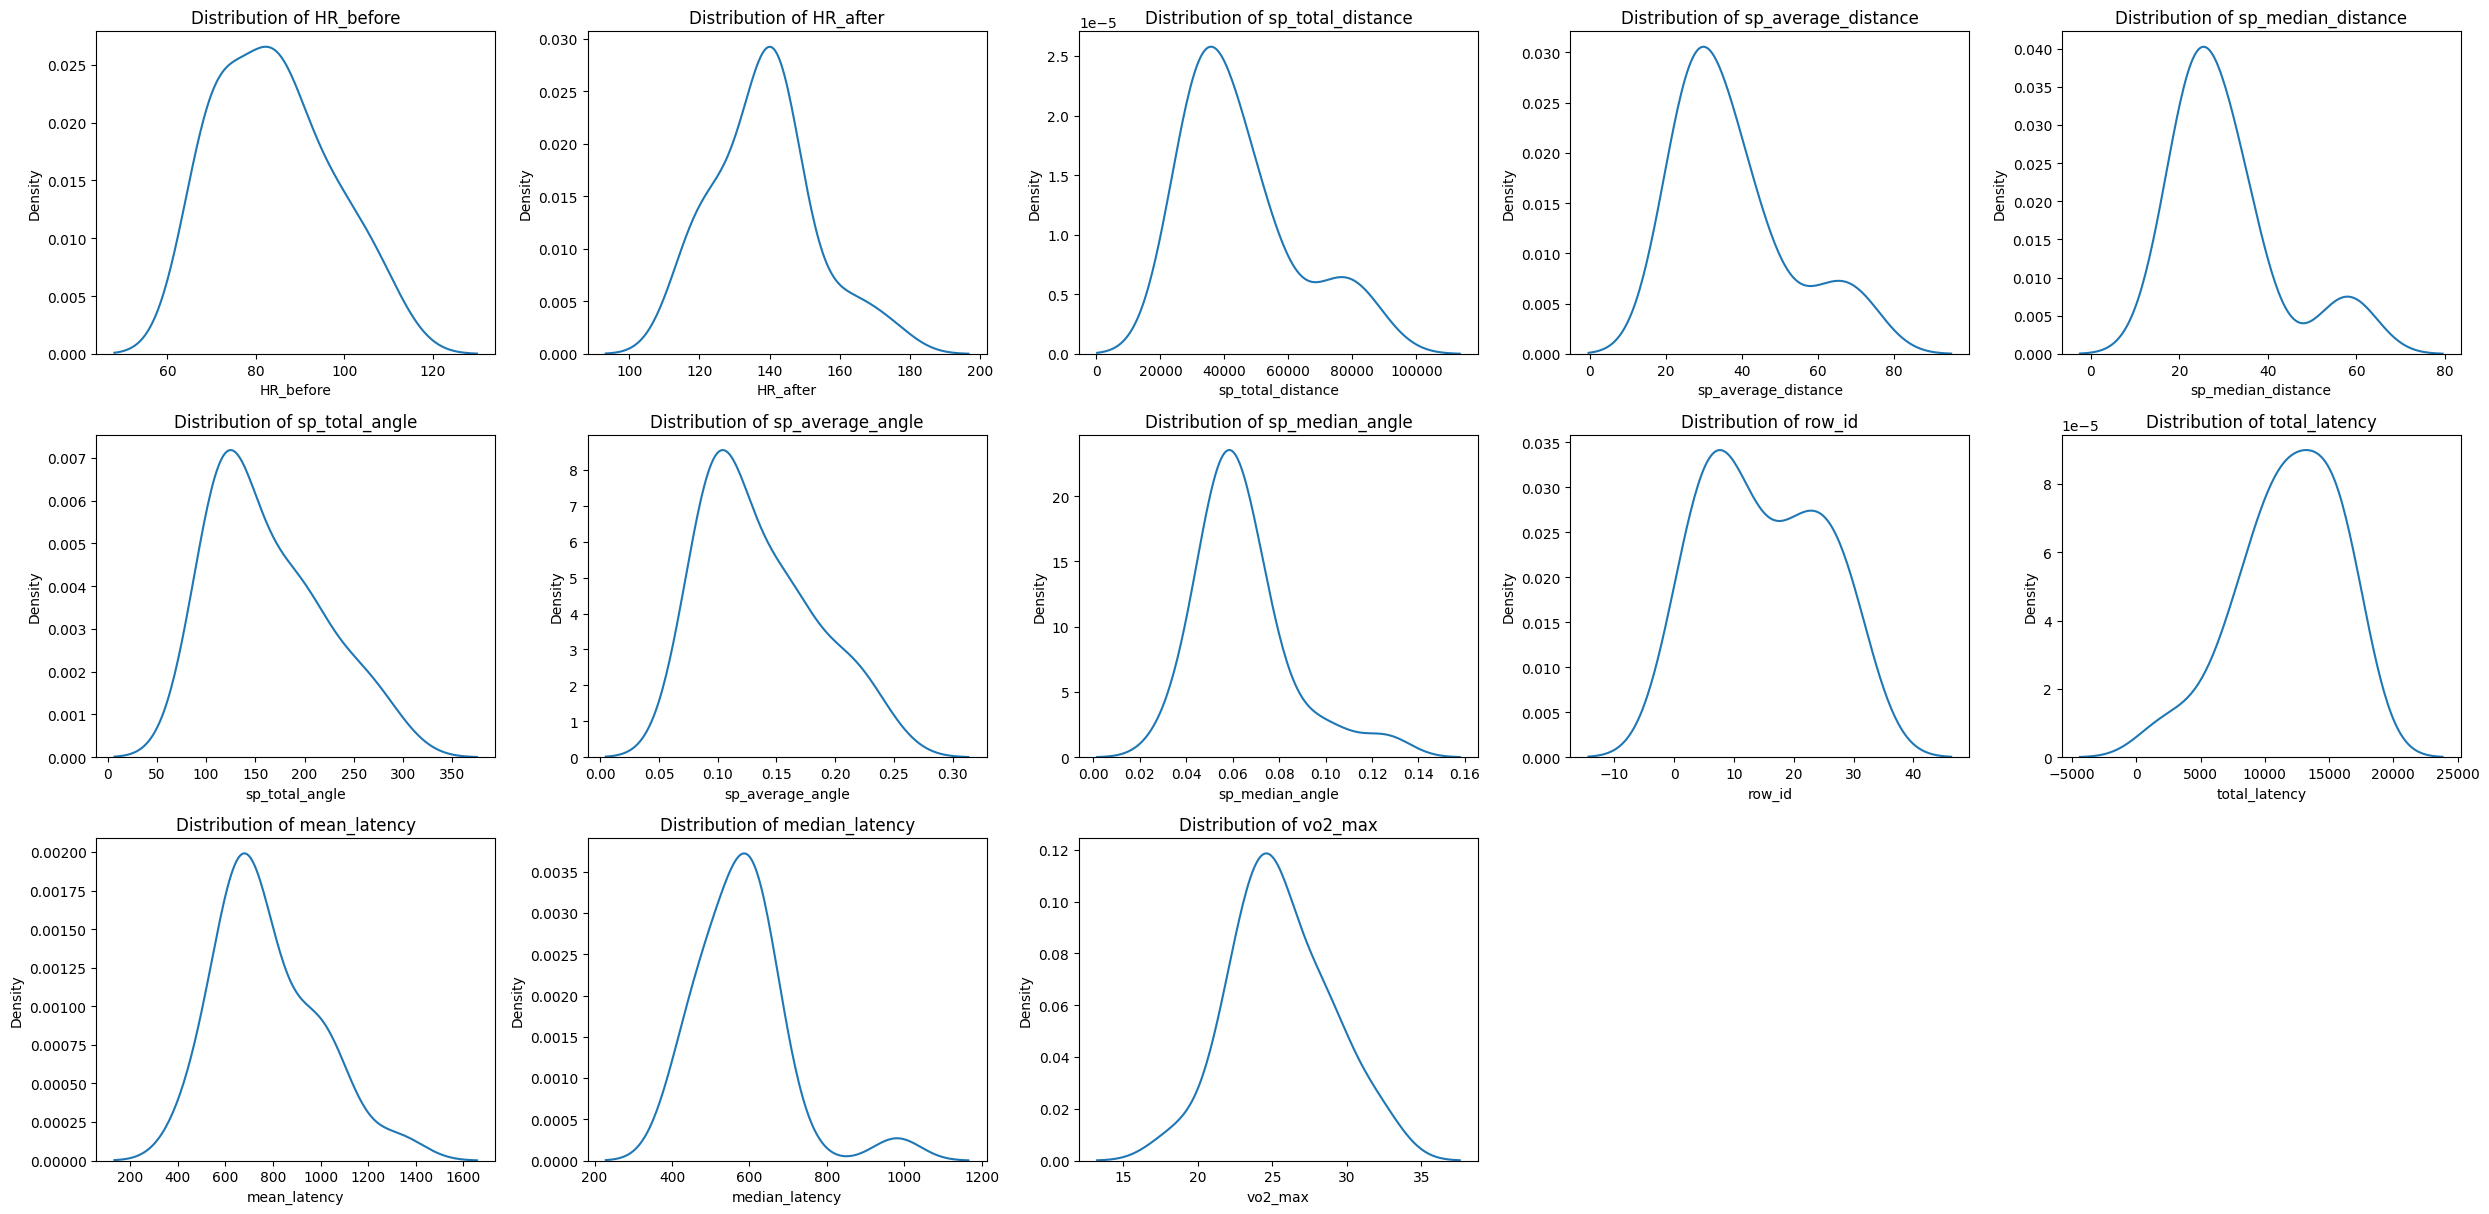

In [42]:
# Define the number of rows and columns you want for your subplots
num_columns = len(df_engineered.columns)
num_rows = int(np.ceil(num_columns / 4))  # Adjust the denominator to change the number of columns per row

# Create a figure object and define the size
plt.figure(figsize=(25, 4 * num_rows))  # Adjust the size as needed

# Loop through the numerical columns and create a subplot for each
for i, column in enumerate(df_engineered.columns):
    plt.subplot(num_rows, 5, i + 1)  # Adjust the number '3' based on the number of columns per row
    sns.kdeplot(data=df_engineered[column])
    plt.title(f"Distribution of {column}")

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()

## Pearson Correlation 

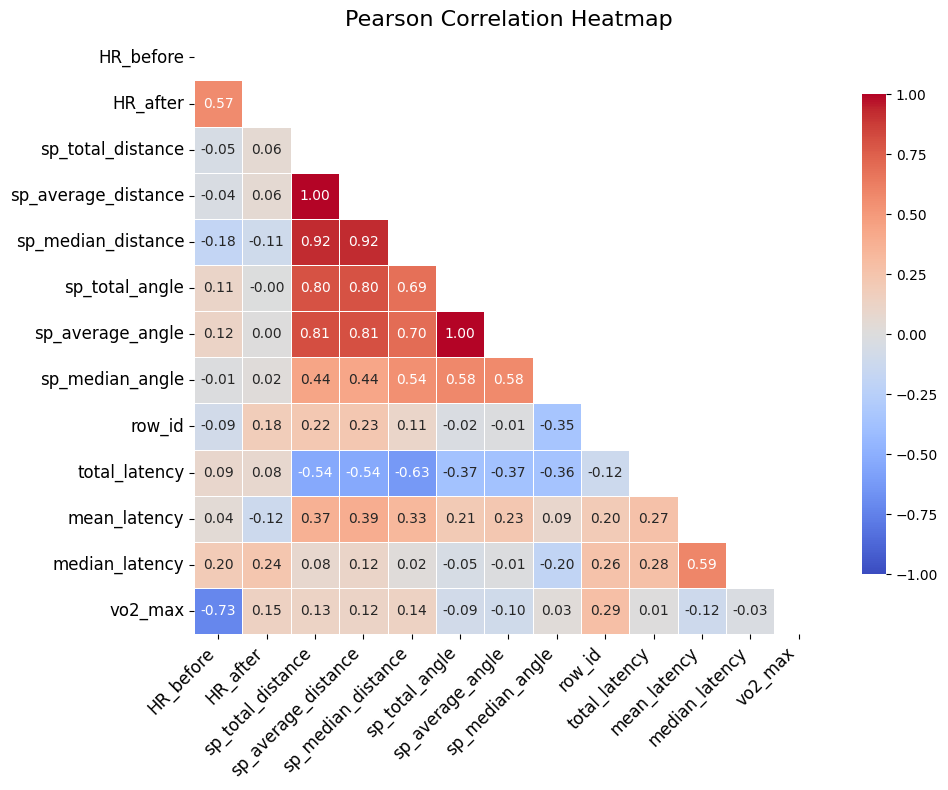

In [43]:
# Compute Pearson correlation
correlation_matrix = df_engineered.corr(method='pearson')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a mask for the upper triangle (optional, to avoid showing duplicate values)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, 
            linewidths=0.5, cbar_kws={'shrink': 0.8}, vmin=-1, vmax=1)

# Improve readability
plt.title('Pearson Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

## Save Data into csv

In [44]:
df_engineered.to_csv('../data/interim/2_data_engineered.csv', index=False)

## Some Visualization

In [45]:
df_trial = df_sem[df_sem['id'] =='bian-2024-10-12_SEM_1728719688']
df_trial[1000:1005]

,Timestamp,MovingTarget_X,MovingTarget_Y,EyeTracker_X,EyeTracker_Y,name,date,category,id,row_id,HR_before,HR_after,age,datetime_timestamp,MovingTarget_X_discrete
14821,1728719848651,1020.0,450.0,913.906800,566.870580,bian,2024-10-12,SEM,bian-2024-10-12_SEM_1728719688,8.0,96.0,143.0,21.0,2024-10-12 07:57:28.651000+00:00,right
14822,1728719849569,1020.0,450.0,1011.843936,491.444847,bian,2024-10-12,SEM,bian-2024-10-12_SEM_1728719688,8.0,96.0,143.0,21.0,2024-10-12 07:57:29.569000+00:00,right
14823,1728719849611,1020.0,450.0,1006.493760,490.448997,bian,2024-10-12,SEM,bian-2024-10-12_SEM_1728719688,8.0,96.0,143.0,21.0,2024-10-12 07:57:29.611000+00:00,right
14824,1728719849652,1020.0,450.0,1006.447738,489.237714,bian,2024-10-12,SEM,bian-2024-10-12_SEM_1728719688,8.0,96.0,143.0,21.0,2024-10-12 07:57:29.652000+00:00,right
14825,1728719849694,1020.0,450.0,1004.233968,494.967555,bian,2024-10-12,SEM,bian-2024-10-12_SEM_1728719688,8.0,96.0,143.0,21.0,2024-10-12 07:57:29.694000+00:00,right


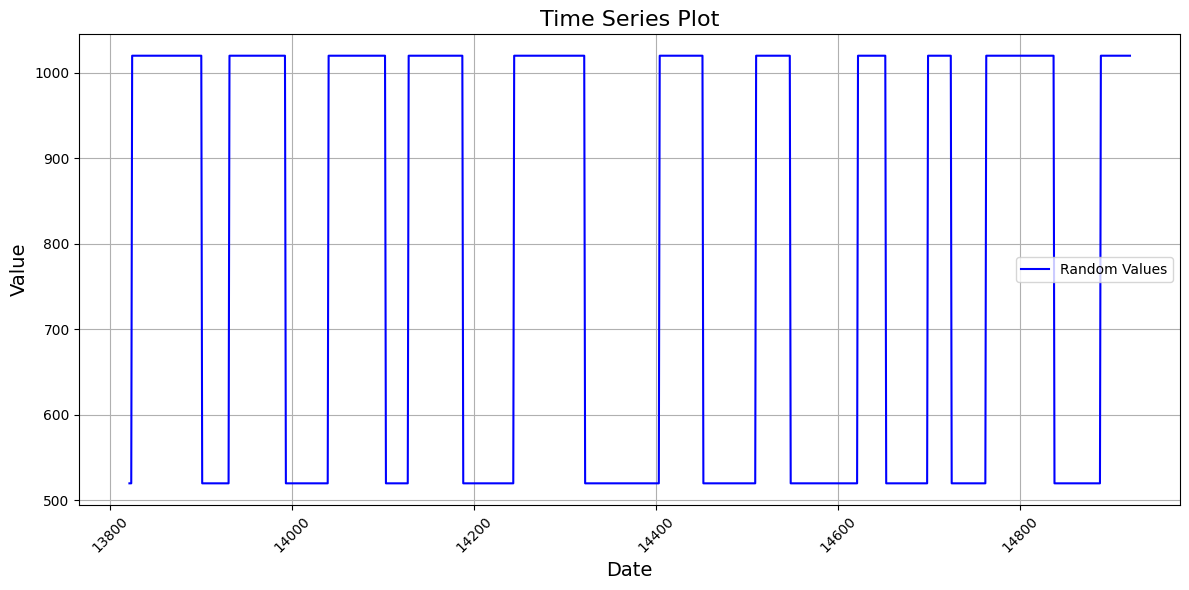

In [46]:
# Plotting the time series

df_trial = df_sem[df_sem['id'] =='bian-2024-10-12_SEM_1728719688']

# Identify the maximum and minimum values
max_value = df_trial['MovingTarget_X'].max()
min_value = df_trial['MovingTarget_X'].min()

# Filter the DataFrame to keep only rows with max or min values
df_filtered = df_trial[(df_trial['MovingTarget_X'] == max_value) | (df_trial['MovingTarget_X'] == min_value)]

plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered['MovingTarget_X'], label='Random Values', color='blue')

# Adding titles and labels
plt.title('Time Series Plot', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.grid()
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()